In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# First, we get the data
dataset = pd.read_csv('./IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [4]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

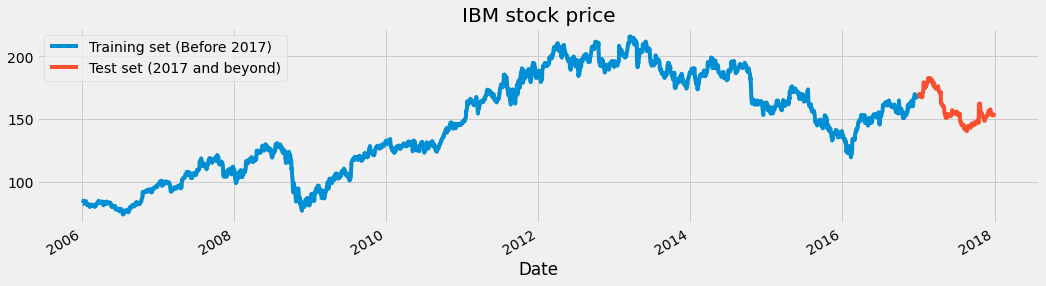

In [4]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

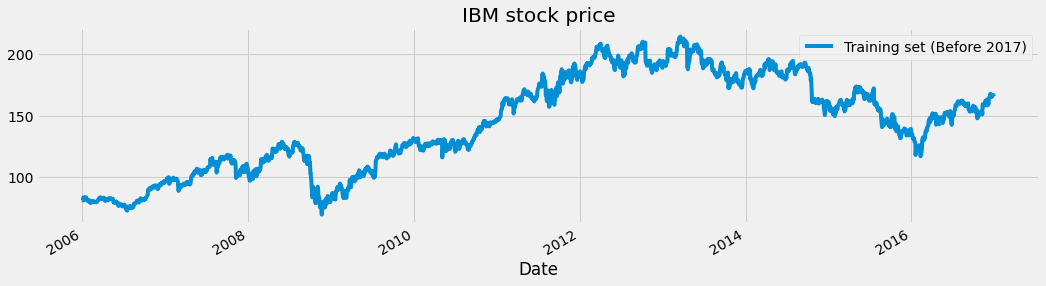

In [7]:
dataset["Low"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["Low"]['2016':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [10]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 20s 60ms/step - loss: 0.0414
Epoch 2/50
85/85 [==============================] - 5s 61ms/step - loss: 0.0110
Epoch 3/50
85/85 [==============================] - 5s 60ms/step - loss: 0.0090
Epoch 4/50
85/85 [==============================] - 5s 58ms/step - loss: 0.0085
Epoch 5/50
85/85 [==============================] - 5s 60ms/step - loss: 0.0063
Epoch 6/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0054
Epoch 7/50
85/85 [==============================] - 5s 58ms/step - loss: 0.0050
Epoch 8/50
85/85 [==============================] - 5s 58ms/step - loss: 0.0049
Epoch 9/50
85/85 [==============================] - 5s 58ms/step - loss: 0.0041
Epoch 10/50
85/85 [==============================] - 5s 60ms/step - loss: 0.0041
Epoch 11/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0034
Epoch 12/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0033
Epoch 13/50
85/85 [=================

In [11]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [1]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

NameError: name 'inputs' is not defined

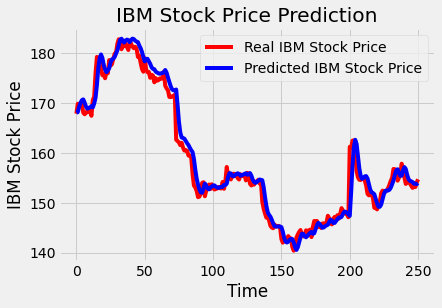

In [13]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [14]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.16643051280371.


In [17]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 6s 108ms/step - loss: 0.1239
Epoch 2/50
19/19 [==============================] - 2s 105ms/step - loss: 0.0376
Epoch 3/50
19/19 [==============================] - 2s 109ms/step - loss: 0.0095
Epoch 4/50
19/19 [==============================] - 2s 116ms/step - loss: 0.0046
Epoch 5/50
19/19 [==============================] - 2s 115ms/step - loss: 0.0040
Epoch 6/50
19/19 [==============================] - 2s 108ms/step - loss: 0.0037
Epoch 7/50
19/19 [==============================] - 2s 111ms/step - loss: 0.0038
Epoch 8/50
19/19 [==============================] - 2s 110ms/step - loss: 0.0034
Epoch 9/50
19/19 [==============================] - 2s 108ms/step - loss: 0.0034
Epoch 10/50
19/19 [==============================] - 2s 111ms/step - loss: 0.0030
Epoch 11/50
19/19 [==============================] - 2s 111ms/step - loss: 0.0032
Epoch 12/50
19/19 [==============================] - 2s 108ms/step - loss: 0.0031
Epoch 13/50
19/19 [======

In [18]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

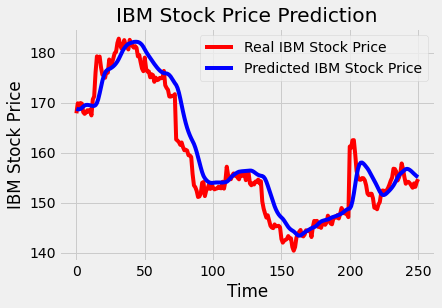

In [19]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [20]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.5717569224615975.


In [21]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

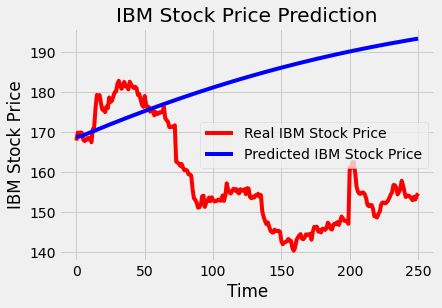

In [22]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [23]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 30.427643329220267.
